# Machine learning with many-body tensor networks

This notebook examines numerically applying tensor networks on many-body quantum physics in a machine learning sense.

In [67]:
import numpy as np
import pandas as pd
import qiskit

from matplotlib import pyplot as plt
# import torch

# os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6"
backend = 'jax'
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [16]:
# %config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [46]:
q = qiskit.QuantumRegister(1)

qc = qiskit.QuantumCircuit(q)
qc.u2(0.4234, np.pi/2, q)
print(qc.draw())
qc.qasm()

    ┌────────────────┐
q4: ┤ U2(0.4234,π/2) ├
    └────────────────┘


/tmp/ipykernel_7074/2231635230.py:4: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  qc.u2(0.4234, np.pi/2, q)


'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q4[1];\nu2(0.4234,pi/2) q4[0];\n'

In [13]:
print(qc.draw('latex_source', style="iqx", initial_state=True))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q1} : \ket{{0}} } & \lstick{{q1} : \ket{{0}} } & \gate{\mathrm{U_2}\,(\mathrm{0.4234,\frac{\pi}{2}})} & \qw & \qw\\
\\ }}
\end{document}


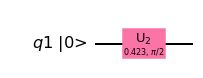

In [14]:
qc.draw('mpl', initial_state=True)

In [18]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3', *params, i,
            gate_round=gate_round, parametrize=True)

def two_qubit_layer(circ, gate2='CZ', reverse=False, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    if reverse:
        regs = reversed(regs)

    for i in regs:
        circ.apply_gate(
            gate2, i, i + 1, gate_round=gate_round)

def ansatz_circuit(n, depth, gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, reverse=r % 2 == 0)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    return circ

In [19]:
n = 6
depth = 9
gate2 = 'CZ'

circ = ansatz_circuit(n, depth, gate2=gate2)
circ

<Circuit(n=6, num_gates=105, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

In [20]:
V = circ.uni

/home/nikosavola/.local/lib/python3.9/site-packages/quimb/tensor/circuit.py:1078: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


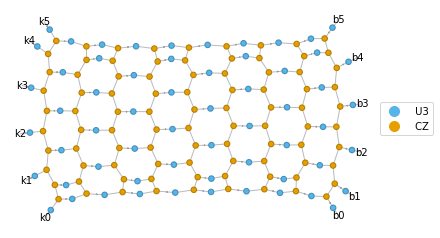

In [21]:
# types of gate
V.draw(color=['U3', gate2], show_inds=True)

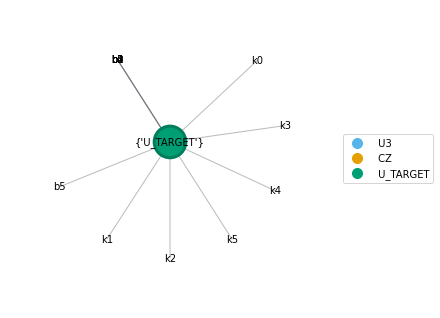

In [22]:
# the hamiltonian
H = qu.ham_ising(n, jz=1.0, bx=0.7, cyclic=False)

# the propagator for the hamiltonian
t = 2
U_dense = qu.expm(-1j * t * H)

# 'tensorized' version of the unitary propagator
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f'k{i}' for i in range(n)] + [f'b{i}' for i in range(n)],
    tags={'U_TARGET'}
)
U.draw(color=['U3', gate2, 'U_TARGET'])

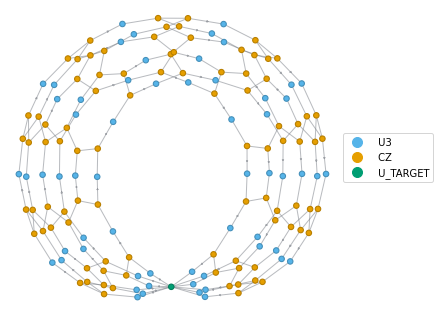

In [23]:
(V.H & U).draw(color=['U3', gate2, 'U_TARGET'])

In [24]:
def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize='auto-hq')) / 2**n

# check our current unitary 'infidelity':
loss(V, U)

0.9892059106059026

In [25]:
tnopt = qtn.TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

In [27]:
# allow 10 hops with 500 steps in each 'basin'
V_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

+0.004613816738 [best: +0.004609405994] :  41%|████      | 2052/5000 [00:48<01:09, 42.40it/s]


In [30]:
V_opt['U3', 'ROUND_4', 'I2'].params

array([ 1.685337 , -0.5165047,  1.4363432], dtype=float32)

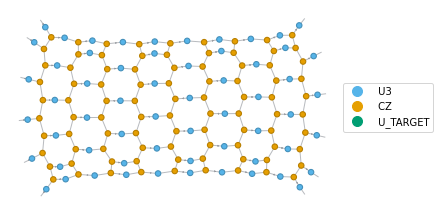

In [31]:
V_opt.draw(color=['U3', gate2, 'U_TARGET'])

In [35]:
# example generated gates
qu.U_gate(*V_opt['U3', 'ROUND_4', 'I3'].params)

[[ 0.999994+0.000000e+00j  0.003552+1.225740e-04j]
 [-0.00205 +2.903424e-03j  0.604662-7.964741e-01j]]

### Test fidelity

In [47]:
V_opt_dense = V_opt.to_dense([f'k{i}' for i in range(n)], [f'b{i}' for i in range(n)])

# random initial state
psi0 = qu.rand_ket(2**n)

# this is the exact state we want
psif_exact = U_dense @ psi0

# this is the state our circuit will produce if fed `psi0`
psif_apprx = V_opt_dense @ psi0

f"Fidelity: {100 * qu.fidelity(psif_apprx, psif_exact):.2f} %"

'Fidelity: 99.57 %'

### Extracting new circuit

In [48]:
circ.update_params_from(V_opt)

# the basic gate specification
circ.gates

[('U3', 0.36248145, 1.2039351, -0.24781941, 0),
 ('U3', -0.0021012698, 0.7663503, 2.0868173, 1),
 ('U3', -1.0089576, -0.42091903, 1.5718956, 2),
 ('U3', -0.71518826, 0.9112304, 1.5697834, 3),
 ('U3', 2.3272877, 1.0021331, 1.5699664, 4),
 ('U3', 0.9203899, 1.2663116, 1.5747931, 5),
 ('CZ', 4, 5),
 ('CZ', 3, 4),
 ('CZ', 2, 3),
 ('CZ', 1, 2),
 ('CZ', 0, 1),
 ('U3', 1.275765, 0.44579867, -0.94574136, 0),
 ('U3', 1.3433957, 0.2751522, -1.28288, 1),
 ('U3', 1.3611602, 1.0960287, 0.42411837, 2),
 ('U3', -0.0018181213, -0.252684, 0.29611582, 3),
 ('U3', 1.2043833, -0.35901222, -0.997012, 4),
 ('U3', 1.4160988, 1.4065094, 0.2513348, 5),
 ('CZ', 0, 1),
 ('CZ', 1, 2),
 ('CZ', 2, 3),
 ('CZ', 3, 4),
 ('CZ', 4, 5),
 ('U3', 0.9821348, 1.692869, 0.9196741, 0),
 ('U3', 1.5520084, 0.094438225, -0.27538595, 1),
 ('U3', -0.07605504, 1.9101498, 2.041775, 2),
 ('U3', 0.0025602644, 0.07839642, 1.3080572, 3),
 ('U3', 0.45921588, 1.4661939, 0.35711345, 4),
 ('U3', 1.9312001, 0.39493516, 0.693857, 5),
 ('CZ', 4

('U3', 0.36248145, 1.2039351, -0.24781941, 0)
('U3', -0.0021012698, 0.7663503, 2.0868173, 1)
('U3', -1.0089576, -0.42091903, 1.5718956, 2)
('U3', -0.71518826, 0.9112304, 1.5697834, 3)
('U3', 2.3272877, 1.0021331, 1.5699664, 4)
('U3', 0.9203899, 1.2663116, 1.5747931, 5)
('CZ', 4, 5)
('CZ', 3, 4)
('CZ', 2, 3)
('CZ', 1, 2)
('CZ', 0, 1)
('U3', 1.275765, 0.44579867, -0.94574136, 0)
('U3', 1.3433957, 0.2751522, -1.28288, 1)
('U3', 1.3611602, 1.0960287, 0.42411837, 2)
('U3', -0.0018181213, -0.252684, 0.29611582, 3)
('U3', 1.2043833, -0.35901222, -0.997012, 4)
('U3', 1.4160988, 1.4065094, 0.2513348, 5)
('CZ', 0, 1)
('CZ', 1, 2)
('CZ', 2, 3)
('CZ', 3, 4)
('CZ', 4, 5)
('U3', 0.9821348, 1.692869, 0.9196741, 0)
('U3', 1.5520084, 0.094438225, -0.27538595, 1)
('U3', -0.07605504, 1.9101498, 2.041775, 2)
('U3', 0.0025602644, 0.07839642, 1.3080572, 3)
('U3', 0.45921588, 1.4661939, 0.35711345, 4)
('U3', 1.9312001, 0.39493516, 0.693857, 5)
('CZ', 4, 5)
('CZ', 3, 4)
('CZ', 2, 3)
('CZ', 1, 2)
('CZ', 0, 1)


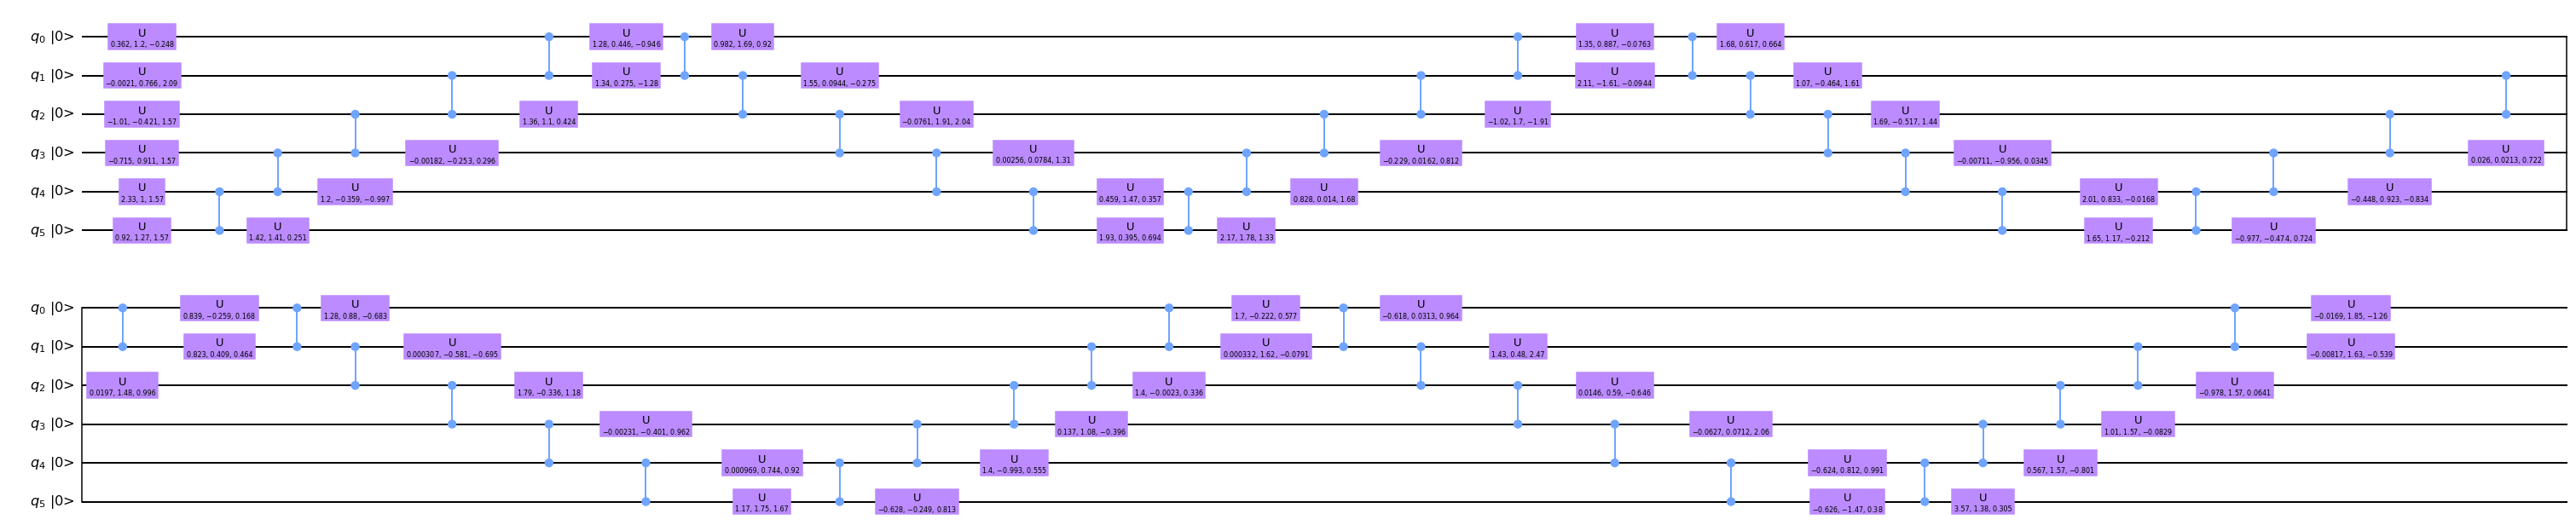

In [95]:
qc = qiskit.QuantumCircuit(n)

for g in circ.gates:
    name, *params = g
    print(g)
    if name == 'U3':
        qc.u(*params)
    elif name == 'CZ':
        qc.cz(*params)

fig = qc.draw('mpl', style="default", initial_state=True, idle_wires=False, fold=64)
fig.savefig('../figures/ansatz_circuit.pdf')
plt.show()
qc.draw('mpl', style="default", initial_state=True, idle_wires=False, fold=64)

In [65]:
latex_src = qc.draw('latex_source', style="iqx", initial_state=True)
# print(latex_src)

In [44]:
qasm_str = circ.to_qasm()
qc_opt = qiskit.QuantumCircuit(qasm_str)



qc_opt.draw()

AttributeError: 'Circuit' object has no attribute 'to_qasm'

In [21]:
dir(circ)

['N',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bra_site_ind_id',
 '_get_sliced_contractor',
 '_group_order',
 '_ket_site_ind_id',
 '_marginal_storage_size',
 '_maybe_init_storage',
 '_parse_qubits_order',
 '_psi',
 '_sample_n_gates',
 '_sampled_conditionals',
 '_storage',
 'amplitude',
 'amplitude_rehearse',
 'amplitude_tn',
 'apply_circuit',
 'apply_gate',
 'apply_gate_raw',
 'apply_gates',
 'bra_site_ind',
 'calc_qubit_ordering',
 'cnot',
 'compute_marginal',
 'compute_marginal_rehearse',
 'compute_marginal_tn',
 'cu1',
 'cu2',
 'cu3',
 'cx',
 'cy',
 'cz',
 'from_qasm',
 'from_qasm_file',
 'from_qasm_url',
 'fsim',
 'fsimg',
 'gate_opts',
 'gates',
 'get_psi

In [22]:
circ.cy

<bound method Circuit.cy of <Circuit(n=6, num_gates=105, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>>

In [24]:
? circ.from_qasm

Signature:  circ.from_qasm(qasm, **quantum_circuit_opts)
Docstring:
Generate a ``Circuit`` instance from a qasm string.
        
File:      ~/.local/lib/python3.9/site-packages/quimb/tensor/circuit.py
Type:      method


In [30]:
circ.gate_opts

{'contract': 'auto-split-gate', 'propagate_tags': 'register'}